In [1]:
import tensorflow as tf
import csv
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import mglearn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize, LabelEncoder
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras import optimizers
from keras.layers.advanced_activations import PReLU, LeakyReLU

Using TensorFlow backend.


In [2]:
%matplotlib inline

### Reading the CSV file and cleaning

feature dataframe has the features read except for the first (seq_num) and the last column (label)
The dataframe also drop the Glucose column and replaces all NaN values and 7,9 (in labels) to 0

Features were also normalized - (features - features.mean())/features.std()

In [3]:
df = pd.read_csv('../Data/new_nhanes.csv')
df = df.iloc[:, 1:]

# replace string values with integers
df['Gender'] = df['Gender'].map({'female': 1, 'male': 0})
df['Diabetes'] = df['Diabetes'].map({'Yes': 1, 'No': 0})

# dropping all NaN in the dataframe
df = df.dropna(axis=0, how='any')

print "Cleaned label counts:"
print df.groupby('Diabetes').size()

#separating features and labels
features = df.iloc[:, 0:-1]
label = df.iloc[:,-1]

print "\n"
print "Columns in the features"
column_names = list(features)
print column_names

#normalizing features - unnormalized also results in similar results
normalized_features = (features - features.mean())/features.std()

Cleaned label counts:
Diabetes
0.0    6987
1.0     648
dtype: int64


Columns in the features
['Gender', 'Age', 'BMI', 'Weight', 'Height', 'TotChol', 'BPSys1', 'BPDia1']


#### Pair-plotting of features - Red is Diabetic, Blue Non-Diabetic

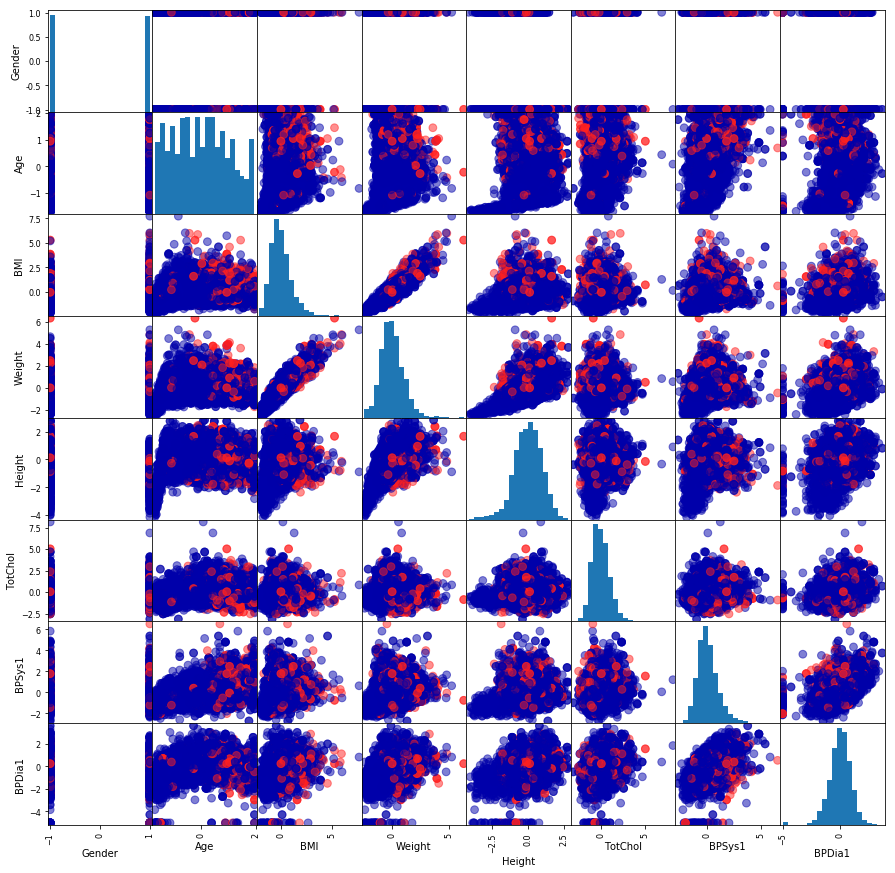

In [4]:
# create a scatter matrix from the dataframe, color by y
grr = pd.scatter_matrix(normalized_features, c=label, figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.5, cmap=mglearn.cm2)

### Formatting input for Machine Learning

In [5]:
# X = features.as_matrix()
X = normalized_features.as_matrix()

Y = label.as_matrix()

print "Shape of the matrices"
print X.shape
print Y.shape

print "\n"
print "Total unique counts by labels"
print np.unique(Y, return_counts=True)

# 70% training and 30% test 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print "\n"
print "Total unique counts by labels for training and testing"
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print np.unique(y_train, return_counts=True)
print np.unique(y_test, return_counts=True)

y_train = keras.utils.to_categorical(y_train, num_classes=None)

print y_train
# y_test = keras.utils.to_categorical(y_test, num_classes=None)


Shape of the matrices
(7635, 8)
(7635,)


Total unique counts by labels
(array([ 0.,  1.]), array([6987,  648]))


Total unique counts by labels for training and testing
(5344, 'train sequences')
(2291, 'test sequences')
(array([ 0.,  1.]), array([4891,  453]))
(array([ 0.,  1.]), array([2096,  195]))
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]


#### Deeplearning

###### Model building

In [ ]:
model = Sequential()
model.add(Dense(512, input_shape=(8,), init='normal'))
model.add(Dense(1024, init='normal', activation='relu'))
model.add(Dense(512, init='normal', activation='relu'))
model.add(Dense(2, init='normal', activation='sigmoid'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = model.fit(x_train, y_train, validation_split=0.0, nb_epoch=150, batch_size=10, verbose=2)

/Users/somya/virtualenvs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", input_shape=(8,))`
  from ipykernel import kernelapp as app
/Users/somya/virtualenvs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
/Users/somya/virtualenvs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal")`
/Users/somya/virtualenvs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="sigmoid", kernel_initializer="normal")`


Epoch 1/150
4s - loss: 0.2711 - acc: 0.9149
Epoch 2/150
3s - loss: 0.2457 - acc: 0.9152
Epoch 3/150
3s - loss: 0.2429 - acc: 0.9152
Epoch 4/150
4s - loss: 0.2408 - acc: 0.9152
Epoch 5/150
3s - loss: 0.2376 - acc: 0.9152
Epoch 6/150
4s - loss: 0.2321 - acc: 0.9152
Epoch 7/150


In [9]:
y_predict = model.predict_classes(x_test, batch_size=10, verbose=0)

In [10]:
print "Test Data"
print y_test
unique, counts = np.unique(y_test, return_counts=True)
print dict(zip(unique, counts))

print '\n'
print "Predicted Data"
print y_predict
unique, counts = np.unique(y_predict, return_counts=True)
print dict(zip(unique, counts))

Test Data
[ 0.  0.  0. ...,  0.  0.  0.]
{0.0: 2096, 1.0: 195}


Predicted Data
[0 0 0 ..., 0 0 0]
{0: 2207, 1: 84}


In [11]:
import itertools
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# These are the tuned paramters

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

     Normal       0.93      0.98      0.96      2096
   Daibetic       0.61      0.26      0.37       195

avg / total       0.91      0.92      0.91      2291

Confusion matrix, without normalization
[[2063   33]
 [ 144   51]]


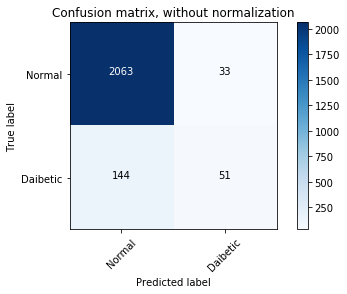

In [14]:
cnf_matrix = confusion_matrix(y_test, y_predict)

target_names = ['Normal', 'Daibetic']
print(classification_report(y_test, y_predict, target_names=target_names))
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')